# Main Dashboard of PhD experiments in pre silicon full

In [1]:
results_file = 'presilicon_results.csv'
import os
from pca.analytics import *
from pre_silicon.presi_data_gen import *
from clustering.distortion import *
from clustering.clustering import *
from clustering.cluster_score import *

# Characterization of worklaods based on instructions kind

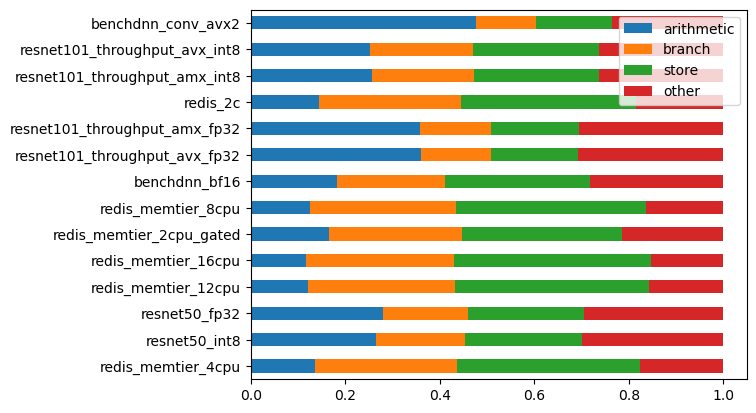

                        test_name  arithmetic    branch     store     other
0              redis_memtier_4cpu    0.136098  0.300828  0.386268  0.176806
1                   resnet50_int8    0.264434  0.187661  0.249620  0.298285
2                   resnet50_fp32    0.279321  0.180546  0.244427  0.295705
3             redis_memtier_12cpu    0.120582  0.311147  0.411406  0.156865
4             redis_memtier_16cpu    0.117199  0.313106  0.417088  0.152608
5        redis_memtier_2cpu_gated    0.164149  0.283461  0.336856  0.215534
6              redis_memtier_8cpu    0.125720  0.307462  0.402709  0.164110
7                   benchdnn_bf16    0.182995  0.228715  0.306698  0.281592
8   resnet101_throughput_avx_fp32    0.360103  0.147215  0.184071  0.308611
9   resnet101_throughput_amx_fp32    0.357238  0.149985  0.186258  0.306519
10                       redis_2c    0.143982  0.301278  0.370414  0.184326
11  resnet101_throughput_amx_int8    0.256101  0.216569  0.263903  0.263427
12  resnet10

In [2]:
files = dir_list = os.listdir("tests/pre_silicon_runs_ml_db")
my_labels = ['arithmetic', 'branch', 'store', 'other']
df_global = pd.DataFrame(columns=my_labels)
for file_name in files:
    test_name = file_name
    df = read_histogram(os.path.join("tests/pre_silicon_runs_ml_db",file_name))
    df_sumary = calcualte_values(df)
    df_global.loc[test_name] = df_sumary['probability'].values.tolist()

plot_stacked_bar(df_global)

df_global.reset_index(inplace=True)
df_global = df_global.rename(columns={"index": "test_name"} )

print(df_global)


df_global.to_csv(results_file)

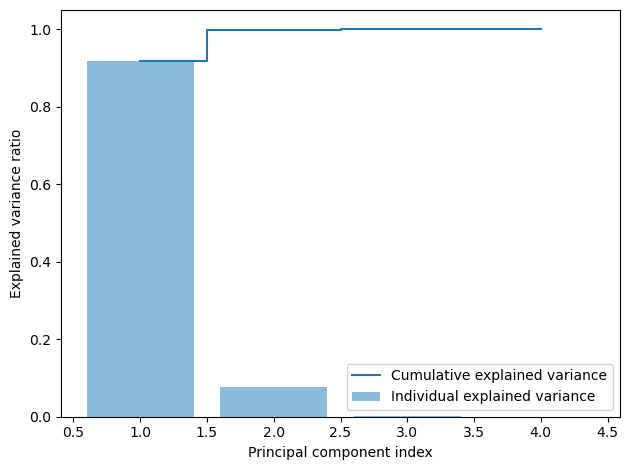

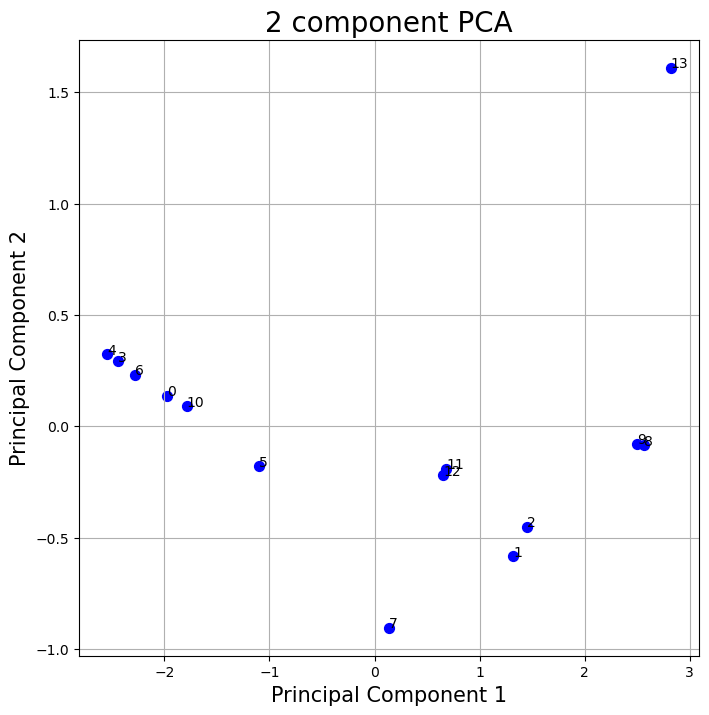

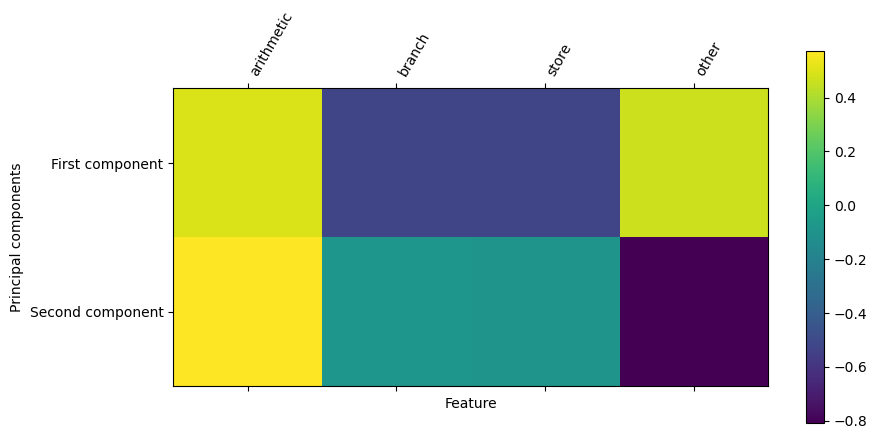

In [3]:

df = df_global

df_ = df.loc[:, df.columns != 'test_name']
df_ = (df_-df_.min())/(df_.max()-df_.min())
extracted_col = df["test_name"]
df_.insert(0, 'test_name', extracted_col)
df_.set_index('test_name')
df_.to_csv('normalized_df.csv')
df = df_

features = list(df.columns)[1:]
test_column = list(df.columns)[0]

pca_df = get_PCA(df, features, test_column)


# Plot characteristics of the worklaods

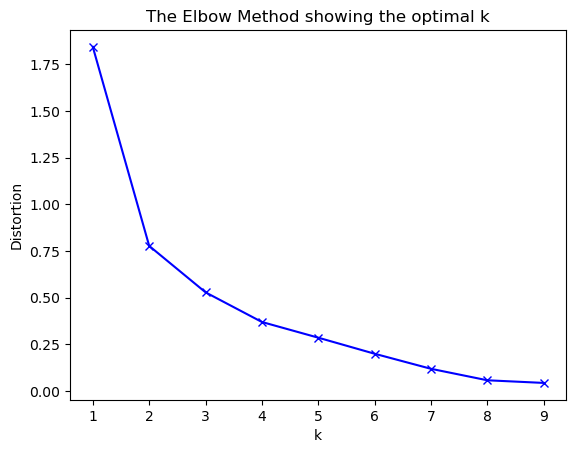

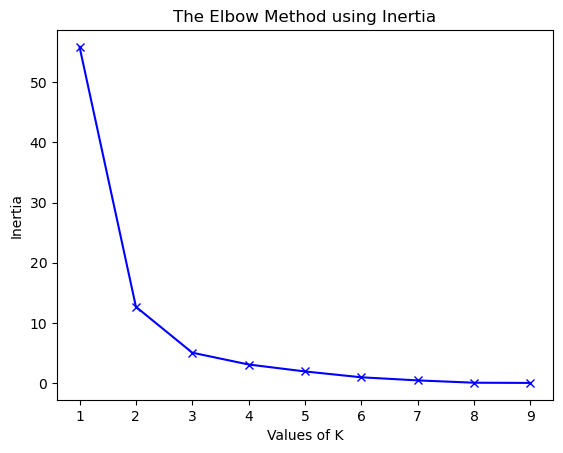

3


In [4]:
if os.path.exists("pca.csv"):    
    clusters = calculate_elbow(pd.read_csv("pca.csv"))

In [5]:
print(f'Optimal number of clusters = {clusters}')

Optimal number of clusters = 3


## Clasification based on optimal number of clusters

<IPython.core.display.Javascript object>


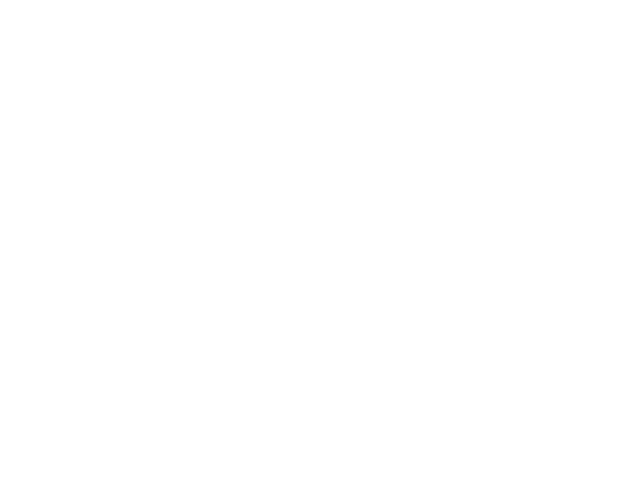

   PRED                      test_name
0     0             redis_memtier_4cpu
0     0            redis_memtier_12cpu
0     0            redis_memtier_16cpu
0     0       redis_memtier_2cpu_gated
0     0             redis_memtier_8cpu
0     0                       redis_2c
1     1                  resnet50_int8
1     1                  resnet50_fp32
1     1                  benchdnn_bf16
1     1  resnet101_throughput_avx_fp32
1     1  resnet101_throughput_amx_fp32
1     1  resnet101_throughput_amx_int8
1     1  resnet101_throughput_avx_int8
1     1             benchdnn_conv_avx2


In [6]:
%matplotlib notebook
df_result,kmeans = kmean_cluster("pca.csv",2)
print(df_result)

In [7]:
df_result,kmeans = kmean_cluster("pca.csv",2)
print(df_result)

   PRED                      test_name
0     0                  resnet50_int8
0     0                  resnet50_fp32
0     0                  benchdnn_bf16
0     0  resnet101_throughput_avx_fp32
0     0  resnet101_throughput_amx_fp32
0     0  resnet101_throughput_amx_int8
0     0  resnet101_throughput_avx_int8
0     0             benchdnn_conv_avx2
1     1             redis_memtier_4cpu
1     1            redis_memtier_12cpu
1     1            redis_memtier_16cpu
1     1       redis_memtier_2cpu_gated
1     1             redis_memtier_8cpu
1     1                       redis_2c


# Get the test cases closer to centroid

In [8]:
from sklearn.metrics import pairwise_distances_argmin_min
X = pd.read_csv("pca.csv", usecols = ['principal component 1','principal component 2'])
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
pca_df = pd.read_csv("pca.csv")
df = pca_df.iloc[closest]
df

,Unnamed: 0,principal component 1,principal component 2,test_name
2,2,1.455567,-0.450666,resnet50_fp32
0,0,-1.977448,0.136824,redis_memtier_4cpu


<IPython.core.display.Javascript object>


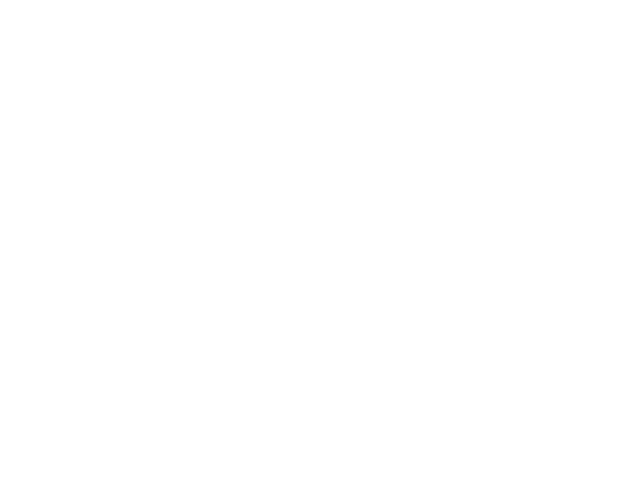

,test_name,arithmetic,branch,store,other
0,redis_memtier_4cpu,0.136098,0.300828,0.386268,0.176806
2,resnet50_fp32,0.279321,0.180546,0.244427,0.295705


In [9]:
list_tests = df['test_name'].tolist()
df2 = df_global[df_global['test_name'].isin(list_tests)]
#plt.rcParams['figure.figsize'] = [15, 4]

df2.plot.barh(x="test_name")
df2

In [10]:
df = pd.read_csv("clusters.csv")
display(df)

labels_true = df["REAL"].tolist()

labels_pred = df["PRED"].tolist()

display(labels_true)
display(labels_pred)

#labels_true = REAL_sorted["REAL"].tolist()

scores_result = scores(labels_true,labels_pred)

df = pd.DataFrame({'scores':['adjusted_rand_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score'], 'val':scores_result[:-1]})
ax = df.plot.barh(x='scores', y='val', rot=0, title= "Scores (HIB)")

,Unnamed: 0,PRED,test_name
0,0,0,resnet50_int8
1,0,0,resnet50_fp32
2,0,0,benchdnn_bf16
3,0,0,resnet101_throughput_avx_fp32
4,0,0,resnet101_throughput_amx_fp32
5,0,0,resnet101_throughput_amx_int8
6,0,0,resnet101_throughput_avx_int8
7,0,0,benchdnn_conv_avx2
8,1,1,redis_memtier_4cpu
9,1,1,redis_memtier_12cpu


KeyError: 'REAL'